In [1]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
import chromedriver_autoinstaller

import time
import random
import subprocess
from datetime import datetime
import missingno as ms
from plotnine import *
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 999)
pd.set_option('display.max_columns', 999)

## Contents:
- Set Selenium options
- Scrape OddsPortal URLs of all NBA Games in a season [saved to .txt file]
- Scrape Bookmaker data from OP URLs into dataframe [saved to pickle]
- Transform Bookmaker dataframe
- Join NBA team identifiers (needed to join to RAPTOR)
- Join RAPTOR scores downloaded from 538

In [2]:
f2020 = pd.read_pickle('nba-2020-2021-with-raptor.pkl')

In [3]:
f2021 = pd.read_pickle('nba-2021-2022-with-raptor.pkl')

In [4]:
f202021 = pd.concat([f2020,f2021])

In [5]:
f2020.shape

(26450, 25)

In [6]:
f2021.shape

(32900, 21)

In [7]:
full = f202021.groupby(by=['date','Home_AbbrB','Away_AbbrB']).sample(n=1)

In [8]:
full.shape

(2485, 25)

In [9]:
full.sample(5)

,date,Home_AbbrB,Away_AbbrB,Bookmaker,Home_Amer,Away_Amer,Home_Imp,Away_Imp,Total_Imp,Full_Payout,Pred_Winner,Actual_Winner,Brier_Score,elo1_pre,elo2_pre,elo_prob1,elo_prob2,raptor1_pre,raptor2_pre,raptor_prob1,raptor_prob2,imp_elo_diff_Home,imp_elo_diff_Away,imp_raptor_diff_Home,imp_raptor_diff_Away
2238,2021-11-12,DEN,ATL,BetInAsia,-161,+145,0.616858,0.408163,1.025022,97.5%,Home,Home,0.146798,1584.794735,1526.132798,0.713681,0.286319,1570.736918,1561.013204,0.704472,0.295528,NaN,NaN,NaN,NaN
18766,2021-02-03,MIA,WAS,10Bet,-455,+355,0.819820,0.219780,1.039600,96.2%,Home,Away,0.672105,1473.549628,1374.013887,0.759259,0.240741,1521.048116,1416.965480,0.785156,0.214844,0.060561,-0.020961,0.034664,0.004936
20352,2021-11-26,UTA,NOP,Betsson,-1000,+640,0.909091,0.135135,1.044226,95.8%,Home,Away,0.826446,1635.883261,1416.845057,0.862538,0.137462,1643.525691,1436.464972,0.876936,0.123064,NaN,NaN,NaN,NaN
11663,2021-03-31,BRK,HOU,1xBet,-909,+769,0.900892,0.115075,1.015967,98.4%,Home,Home,0.009822,1602.223965,1329.240960,0.895394,0.104606,1606.219315,1363.579883,0.863788,0.136212,0.005498,0.010469,0.037104,-0.021138
5123,2020-12-30,LAC,POR,10Bet,-238,+200,0.704142,0.333333,1.037475,96.4%,Home,Home,0.087532,1570.539864,1512.218638,0.713280,0.286720,1567.166789,1555.567036,0.552634,0.447366,-0.009138,0.046614,0.151508,-0.114033


In [10]:
# full.date.value_counts().sort_index()

In [11]:
full['imp_elo_diff_Home'] = full['Home_Imp'] - full['elo_prob1']
full['imp_elo_diff_Away'] = full['Away_Imp'] - full['elo_prob2']
full['imp_raptor_diff_Home'] = full['Home_Imp'] - full['raptor_prob1']
full['imp_raptor_diff_Away'] = full['Away_Imp'] - full['raptor_prob2']

def get_minimum_implied_raptor_difference(row):
    return min(row['imp_raptor_diff_Home'], row['imp_raptor_diff_Away'])

full['min_imp_raptor_diff'] = full.apply(get_minimum_implied_raptor_difference, axis=1)

### Difference between RAPTOR and Bookmaker Implied Odds

<AxesSubplot:>

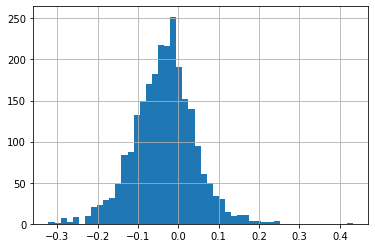

In [12]:
full.imp_raptor_diff_Home.hist(bins=50) # Home teams

<AxesSubplot:>

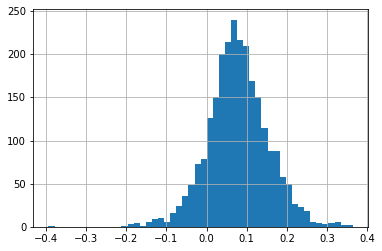

In [13]:
full.imp_raptor_diff_Away.hist(bins=50) # Away Teams

### Difference between ELO and Bookmaker Implied Odds

<AxesSubplot:>

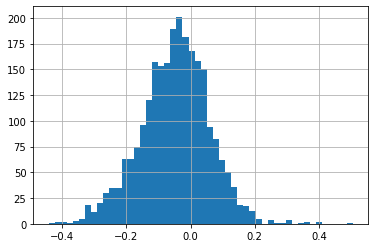

In [14]:
full.imp_elo_diff_Home.hist(bins=50) # Home teams

<AxesSubplot:>

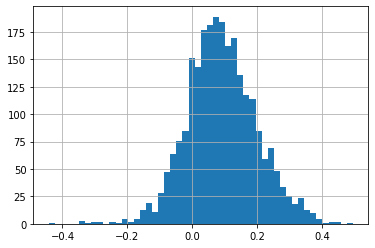

In [15]:
full.imp_elo_diff_Away.hist(bins=50) # Away Teams

In [37]:
def place_bet(row, team):
    if row[f'imp_elo_diff_{team}'] < -0.05:
        return 1 + ((1 + abs(row[f'imp_raptor_diff_{team}']))*3)**2
    else:
        return 0
    
def calculate_return(row, team):
    if row[f'bet_{team}'] == 0:
        return 0
    if row['Actual_Winner'] != f'{team}':
        return 0
    else:
        odds = int(row[f'{team}_Amer'])
        if odds < 0:
            return row[f'bet_{team}'] + ((100/abs(odds)) * row[f'bet_{team}'])
        if odds > 0:
            return row[f'bet_{team}'] + ((odds/100) * row[f'bet_{team}'])

In [38]:
full['bet_Home'] = full.apply(place_bet, team='Home', axis=1)
# full['bet_Home'] = 0

full['bet_Away'] = full.apply(place_bet, team='Away', axis=1)
# full['bet_Away'] = 0


full['return_Home'] = full.apply(calculate_return, team='Home', axis=1)
# full['return_Home'] = 0

full['return_Away'] = full.apply(calculate_return, team='Away', axis=1)
# full['return_Away'] = 0

full['profit_Home'] = full['return_Home'] - full['bet_Home']
full['profit_Away'] = full['return_Away'] - full['bet_Away']
full['profit_Total'] = full['profit_Home'] + full['profit_Away']

In [39]:
subset = full[[
    'date',
    'Home_AbbrB','Away_AbbrB','Bookmaker',
    'Home_Amer','Away_Amer',
    'Home_Imp','Away_Imp',
    'elo_prob1','elo_prob2',
    'raptor_prob1','raptor_prob2',
    'imp_elo_diff_Home','imp_elo_diff_Away',
    'imp_raptor_diff_Home','imp_raptor_diff_Away',
    'bet_Home','bet_Away',
    'return_Home','return_Away',
    'profit_Home','profit_Away']]

### Home Bets

In [40]:
len(full[full['bet_Home'] > 0])

1183

### Away Bets

In [41]:
len(full[full['bet_Away'] > 0])

201

In [42]:
total_bets = len(full[full['bet_Home'] > 0]) + len(full[full['bet_Away'] > 0])

print(f'Total Bets Made: {total_bets}')

total_bet_amount = sum(full['bet_Home']) + sum(full['bet_Away'])
print(f'Total Amount Bet: {"${:,.0f}".format(total_bet_amount)}')

Total Bets Made: 1384
Total Amount Bet: $15,889


In [43]:
bets_won = (full['profit_Home'] > 0).sum() + (full['profit_Away'] > 0).sum()
bets_lost = (full['profit_Home'] < 0).sum() + (full['profit_Away'] < 0).sum()
print(f'Total Bets Won: {bets_won}')
print(f'Total Bets Lost: {bets_lost}')
print(f'Bet Win Percentage: {round(100*bets_won/(bets_won + bets_lost),2)}%')

Total Bets Won: 606
Total Bets Lost: 778
Bet Win Percentage: 43.79%


In [44]:
print(f'Total Amount Bet: {"${:,.0f}".format(total_bet_amount)}')

total_winnings = full['return_Home'].sum() + full['return_Away'].sum()
print(f'Total Winnings: {"${:,.0f}".format(total_winnings)}')

total_profit = full['profit_Home'].sum() + full['profit_Away'].sum()
print(f'Total Profit: {"${:,.0f}".format(total_profit)}')

total_roi = 100 * total_profit / total_bet_amount
print(f'Total ROI: {"{:.2f}%".format(total_roi)}')

Total Amount Bet: $15,889
Total Winnings: $15,008
Total Profit: $-881
Total ROI: -5.55%


In [45]:
bets = full[(full['bet_Home'] > 0) | (full['bet_Away'] > 0)]

In [46]:
bets = bets.sort_values(by=['date'])

In [47]:
bets['cumulative_profit'] = bets['profit_Total'].cumsum()

In [48]:
len(bets)

1384

In [49]:
bets.head()

,date,Home_AbbrB,Away_AbbrB,Bookmaker,Home_Amer,Away_Amer,Home_Imp,Away_Imp,Total_Imp,Full_Payout,Pred_Winner,Actual_Winner,Brier_Score,elo1_pre,elo2_pre,elo_prob1,elo_prob2,raptor1_pre,raptor2_pre,raptor_prob1,raptor_prob2,imp_elo_diff_Home,imp_elo_diff_Away,imp_raptor_diff_Home,imp_raptor_diff_Away,min_imp_raptor_diff,bet_Home,bet_Away,return_Home,return_Away,profit_Home,profit_Away,profit_Total,cumulative_profit
16155,2020-12-22,LAL,LAC,bet-at-home,-137,+106,0.578059,0.485437,1.063496,94.2%,Home,Away,0.334152,1646.074269,1597.210382,0.702019,0.297981,1657.943018,1646.436807,0.616975,0.383025,-0.123960,0.187456,-0.038916,0.102412,-0.038916,10.714118,0.0,0.000000,0.0,-10.714118,0.0,-10.714118,-10.714118
3303,2020-12-23,BOS,MIL,Betsafe,+160,-192,0.384615,0.657534,1.042150,95.9%,Away,Home,0.432351,1645.596807,1604.757537,0.692266,0.307734,1600.528777,1646.595178,0.540789,0.459211,-0.307651,0.349801,-0.156174,0.198323,-0.156174,13.030636,0.0,33.879654,0.0,20.849018,0.0,20.849018,10.134900
10630,2020-12-23,CHI,ATL,ComeOn,+110,-125,0.476190,0.555556,1.031746,96.9%,Away,Away,0.197531,1383.306729,1385.050265,0.637750,0.362250,1413.524703,1477.025554,0.520994,0.479006,-0.161559,0.193305,-0.044804,0.076550,-0.044804,10.824532,0.0,0.000000,0.0,-10.824532,0.0,-10.824532,-0.689632
26193,2020-12-23,CLE,CHO,BetVictor,+120,-154,0.454545,0.606299,1.060845,94.3%,Away,Home,0.367599,1363.405354,1424.016258,0.556444,0.443556,1369.335355,1409.311095,0.554283,0.445717,-0.101898,0.162743,-0.099738,0.160583,-0.099738,11.884811,0.0,26.146585,0.0,14.261773,0.0,14.261773,13.572142
27136,2020-12-23,ORL,MIA,BetVictor,+145,-200,0.408163,0.666667,1.074830,93.0%,Away,Home,0.444444,1494.650805,1603.157646,0.487760,0.512240,1512.204453,1585.032098,0.497943,0.502057,-0.079597,0.154427,-0.089779,0.164609,-0.089779,11.688572,0.0,28.637002,0.0,16.948430,0.0,16.948430,30.520572


In [50]:
import matplotlib.dates as mdates

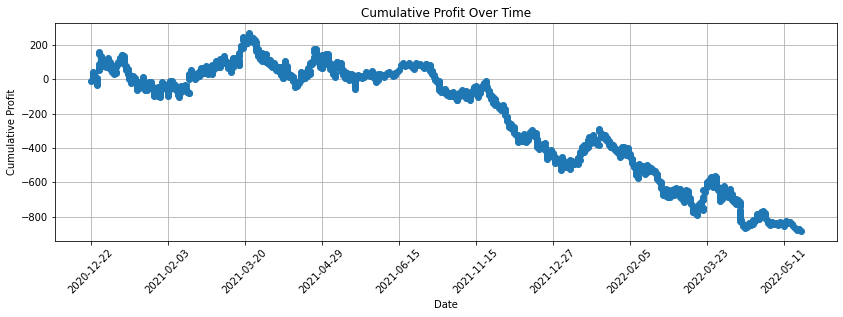

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# Assuming your dataframe is named 'bets'
# ... (your previous code for adding total_profit and sorting the dataframe)

# Step 4: Plot the cumulative profit over time using matplotlib
plt.figure(figsize=(14, 4))
plt.plot(bets['date'], bets['cumulative_profit'], marker='o')

# Set the x-axis format
ax = plt.gca()
ax.xaxis.set_major_locator(MaxNLocator(12))  # Set the maximum number of x-axis ticks to 6
plt.xticks(rotation=45)  # Rotate the ticks for better readability

plt.xlabel('Date')
plt.ylabel('Cumulative Profit')
plt.title('Cumulative Profit Over Time')
plt.grid()
plt.show()

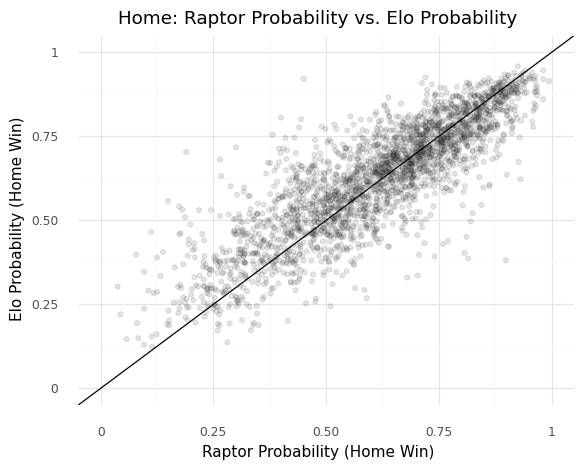

<ggplot: (180706309463)>

In [31]:
(ggplot(full, aes(x='raptor_prob1', y='elo_prob1'))
+ geom_point(alpha=0.1)
+ xlim(0,1)
+ ylim(0,1)
+ geom_abline(slope=1, intercept=0)
+ labs(title='Home: Raptor Probability vs. Elo Probability',
       x='Raptor Probability (Home Win)',
       y='Elo Probability (Home Win)')
+ theme_minimal())

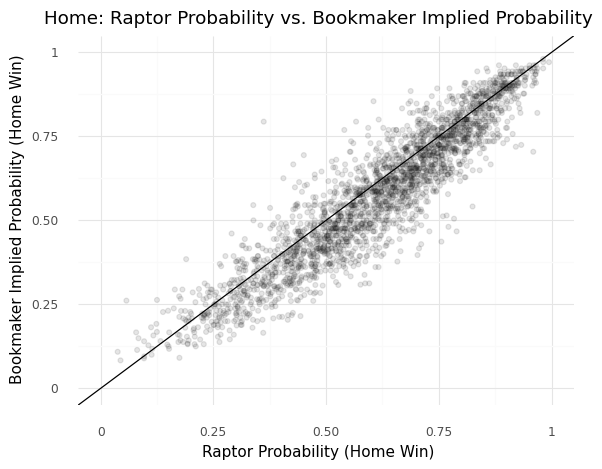

<ggplot: (180706345687)>

In [32]:
(ggplot(full, aes(x='raptor_prob1', y='Home_Imp'))
+ geom_point(alpha=0.1)
+ xlim(0,1)
+ ylim(0,1)
+ geom_abline(slope=1, intercept=0)
+ labs(title='Home: Raptor Probability vs. Bookmaker Implied Probability',
       x='Raptor Probability (Home Win)',
       y='Bookmaker Implied Probability (Home Win)')
+ theme_minimal())

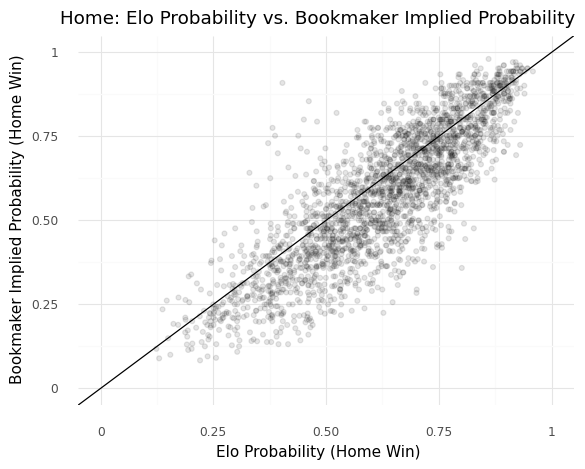

<ggplot: (180706345549)>

In [33]:
(ggplot(full, aes(x='elo_prob1', y='Home_Imp'))
+ geom_point(alpha=0.1)
+ xlim(0,1)
+ ylim(0,1)
+ geom_abline(slope=1, intercept=0)
+ labs(title='Home: Elo Probability vs. Bookmaker Implied Probability',
       x='Elo Probability (Home Win)',
       y='Bookmaker Implied Probability (Home Win)')
+ theme_minimal())

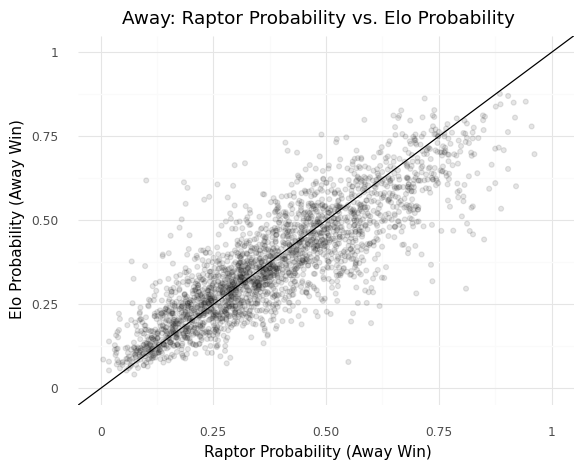

<ggplot: (180706284382)>

In [34]:
(ggplot(full, aes(x='raptor_prob2', y='elo_prob2'))
+ geom_point(alpha=0.1)
+ xlim(0,1)
+ ylim(0,1)
+ geom_abline(slope=1, intercept=0)
+ labs(title='Away: Raptor Probability vs. Elo Probability',
       x='Raptor Probability (Away Win)',
       y='Elo Probability (Away Win)')
+ theme_minimal())

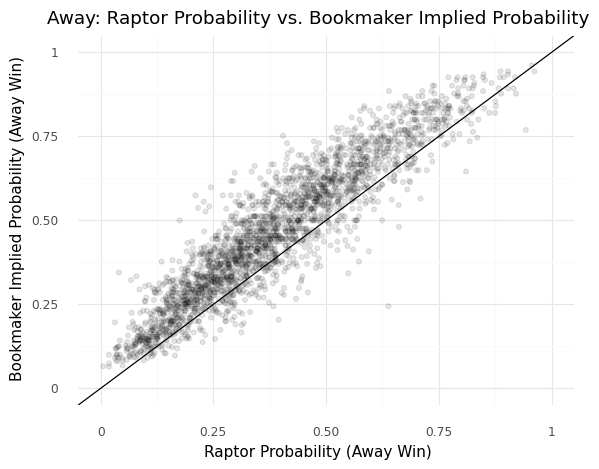

<ggplot: (180706650572)>

In [35]:
(ggplot(full, aes(x='raptor_prob2', y='Away_Imp'))
+ geom_point(alpha=0.1)
+ xlim(0,1)
+ ylim(0,1)
+ geom_abline(slope=1, intercept=0)
+ labs(title='Away: Raptor Probability vs. Bookmaker Implied Probability',
       x='Raptor Probability (Away Win)',
       y='Bookmaker Implied Probability (Away Win)')
+ theme_minimal())

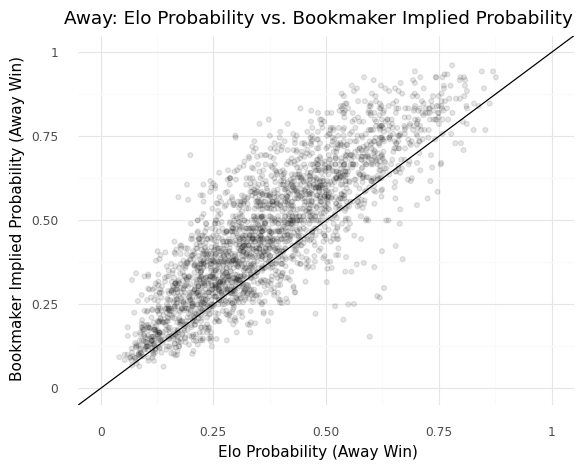

<ggplot: (180706787578)>

In [36]:
(ggplot(full, aes(x='elo_prob2', y='Away_Imp'))
+ geom_point(alpha=0.1)
+ xlim(0,1)
+ ylim(0,1)
+ geom_abline(slope=1, intercept=0)
+ labs(title='Away: Elo Probability vs. Bookmaker Implied Probability',
       x='Elo Probability (Away Win)',
       y='Bookmaker Implied Probability (Away Win)')
+ theme_minimal())